# Deep Learning With Keras To Predict Customer Churn

Using Keras to predict customer churn based on the IBM Watson Telco Customer Churn dataset. 

### Load Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
from tensorflow.keras import layers
import warnings


print(tf.VERSION)
print(tf.keras.__version__)

Using TensorFlow backend.


1.12.0
2.1.6-tf


### Import Data

In [2]:
churn_data_raw = pd.read_csv("telco.csv")

In [3]:
churn_data_raw.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
churn_data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

### Preprocess Data

__Purne the data__

The data has a few columns and rows we’d like to remove:

The “customerID” column is a unique identifier for each observation that isn’t needed for modeling. We can de-select this column.
The data has 11 NA values all in the “TotalCharges” column. Because it’s such a small percentage of the total population (99.8% complete cases), 
we can drop these observations with the drop_na() function from tidyr. Note that these may be customers that have not yet been charged, 
and therefore an alternative is to replace with zero or -99 to segregate this population from the rest.

In [5]:
# Remove customerId
churn_data_raw.pop("customerID")
#churn_data_raw.drop(churn_data_raw.columns[0], axis=1)

# In order to handle missing values, we need to replace the 'blank spaces' value with a numpy NaN value
churn_data_raw.replace(' ', np.nan, inplace=True)

# Print how many missing values contains TotalCharges.
print("Missing values: ", churn_data_raw['TotalCharges'].isnull().sum())

# We remove the ovservations that contain missing values since it's a small percentage of the population
churn_data_raw = churn_data_raw[pd.notnull(churn_data_raw['TotalCharges'])]

churn_data_raw['TotalCharges'] = churn_data_raw.TotalCharges.astype(float)

Missing values:  11


In [6]:
churn_data_raw.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,64.798208,2283.300441
std,0.368844,24.545260,30.085974,2266.771362
min,0.000000,1.000000,18.250000,18.800000
25%,0.000000,9.000000,35.587500,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.862500,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


### Exploration: What Transformation Steps Are Needed For ML?

This phase of the analysis is often called exploratory analysis, but basically we are trying to answer the question, “What steps are needed to prepare for ML?” The key concept is knowing what transformations are needed to run the algorithm most effectively. Artificial Neural Networks are best when the data is one-hot encoded, scaled and centered. In addition, other transformations may be beneficial as well to make relationships easier for the algorithm to identify.

__Discretize the “Tenure” feature__

Numeric features like age, years worked, length of time in a position can generalize a group (or cohort). We see this in marketing a lot (think “millennials”, which identifies a group born in a certain timeframe). The “tenure” feature falls into this category of numeric features that can be discretized into groups.

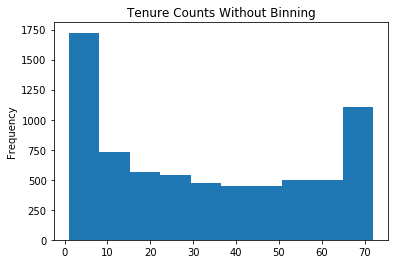

In [7]:
churn_data_raw["tenure"].plot(kind="hist", title = "Tenure Counts Without Binning")

We can split into six cohorts that divide up the user base by tenure in roughly one year (12 month) increments. This should help the ML algorithm detect if a group is more/less susceptible to customer churn.

In [8]:
churn_data_raw["tenure"] = pd.qcut(churn_data_raw["tenure"], 6)
churn_data_raw.head(10)
#churn_data_raw["tenure"].plot(kind="hist", title = "Tenure Counts With 6 Bins") 

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,"(0.999, 4.0]",No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,"(29.0, 47.0]",Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,"(0.999, 4.0]",Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,"(29.0, 47.0]",No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,"(0.999, 4.0]",Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
5,Female,0,No,No,"(4.0, 14.0]",Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.50,Yes
6,Male,0,No,Yes,"(14.0, 29.0]",Yes,Yes,Fiber optic,No,Yes,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,No
7,Female,0,No,No,"(4.0, 14.0]",No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.90,No
8,Female,0,Yes,No,"(14.0, 29.0]",Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes
9,Male,0,No,Yes,"(47.0, 64.0]",Yes,No,DSL,Yes,Yes,No,No,No,No,One year,No,Bank transfer (automatic),56.15,3487.95,No


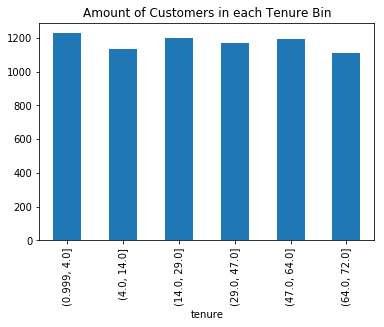

In [9]:
ts = churn_data_raw["tenure"]
ts.groupby(ts).count().plot(kind="bar", figsize=(6, 4),
                                           title="Amount of Customers in each Tenure Bin")

### Transform the “TotalCharges” feature

What we don’t like to see is when a lot of observations are bunched within a small part of the range. We can use a log transformation to even out the data into more of a normal distribution. It’s not perfect, but it’s quick and easy to get our data spread out a bit more.

In [10]:
# Map Churn in order to convert 'Yes' to 1 and 'No' to 0
churn_data_raw['Churn'] = churn_data_raw['Churn'].apply(lambda x: 0 if x=='No' else 1)

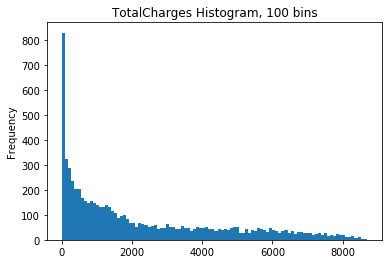

In [11]:
churn_data_raw["TotalCharges"].plot(kind="hist", bins=100, title = "TotalCharges Histogram, 100 bins")

In [12]:
print("Correlation between Churn and TotalCharges:")
np.corrcoef(churn_data_raw["TotalCharges"], churn_data_raw["Churn"])[1,0]

Correlation between Churn and TotalCharges:


-0.1994840835675642

In [13]:
# Careful!!! Every time this cell is executed, a log transformatio will be applied to 'TotalCharges' every time.
churn_data_raw['TotalCharges'] = np.log(churn_data_raw['TotalCharges'])
churn_data_raw["TotalCharges"].head()

0    3.396185
1    7.544068
2    4.683519
3    7.517928
4    5.021575
Name: TotalCharges, dtype: float64

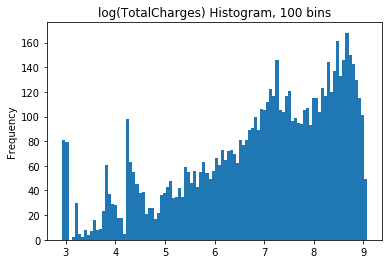

In [14]:
churn_data_raw["TotalCharges"].plot(kind="hist", bins=100, title = "log(TotalCharges) Histogram, 100 bins")

Implement correlation between LogTotalCharges and Churn...  

In [15]:
print("Correlation between Churn and LogTotalCharges:")
np.corrcoef(churn_data_raw["TotalCharges"], churn_data_raw["Churn"])[1,0]


Correlation between Churn and LogTotalCharges:


-0.2417613223313746

The correlation between “Churn” and “LogTotalCharges” is greatest in magnitude indicating the log transformation should improve the accuracy of the ANN model we build. Therefore, we should perform the log transformation.

### One-hot encoding

One-hot encoding is the process of converting categorical data to sparse data, which has columns of only zeros and ones (this is also called creating “dummy variables” or a “design matrix”). All non-numeric data will need to be converted to dummy variables. This is simple for binary Yes/No data because we can simply convert to 1’s and 0’s. It becomes slightly more complicated with multiple categories, which requires creating new columns of 1’s and 0's for each category (actually one less). We have four features that are multi-category: Contract, Internet Service, Multiple Lines, and Payment Method.

In [16]:
categorical_variables = ["gender", "Partner", "Dependents", "tenure", "PhoneService", "MultipleLines", "InternetService", "OnlineBackup", "OnlineSecurity", "Contract", 
                         "PaperlessBilling", "PaymentMethod", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies"]

for variable in categorical_variables:
    dummies = pd.get_dummies(churn_data_raw[variable], prefix = variable)
    # Update churn_data_raw to include dummies and drop the main variables
    churn_data_raw = pd.concat([churn_data_raw, dummies], axis = 1)
    churn_data_raw.drop([variable], axis = 1, inplace = True)
    
list(churn_data_raw.columns.values)

['SeniorCitizen',
 'MonthlyCharges',
 'TotalCharges',
 'Churn',
 'gender_Female',
 'gender_Male',
 'Partner_No',
 'Partner_Yes',
 'Dependents_No',
 'Dependents_Yes',
 'tenure_(0.999, 4.0]',
 'tenure_(4.0, 14.0]',
 'tenure_(14.0, 29.0]',
 'tenure_(29.0, 47.0]',
 'tenure_(47.0, 64.0]',
 'tenure_(64.0, 72.0]',
 'PhoneService_No',
 'PhoneService_Yes',
 'MultipleLines_No',
 'MultipleLines_No phone service',
 'MultipleLines_Yes',
 'InternetService_DSL',
 'InternetService_Fiber optic',
 'InternetService_No',
 'OnlineBackup_No',
 'OnlineBackup_No internet service',
 'OnlineBackup_Yes',
 'OnlineSecurity_No',
 'OnlineSecurity_No internet service',
 'OnlineSecurity_Yes',
 'Contract_Month-to-month',
 'Contract_One year',
 'Contract_Two year',
 'PaperlessBilling_No',
 'PaperlessBilling_Yes',
 'PaymentMethod_Bank transfer (automatic)',
 'PaymentMethod_Credit card (automatic)',
 'PaymentMethod_Electronic check',
 'PaymentMethod_Mailed check',
 'DeviceProtection_No',
 'DeviceProtection_No internet ser

When one-hot encoding for example gender (gender_Male and gender_Female), produces two features which are perfectly negatively correlated, so it is suggested just using one of them, effectively setting the baseline to say male.

In [17]:
extra_dummies = ["gender_Female", "Partner_No", "Dependents_No","PhoneService_No",
                 "PaperlessBilling_No", "InternetService_DSL", "Contract_Month-to-month",
                 "PaymentMethod_Bank transfer (automatic)", "MultipleLines_No", "OnlineBackup_No",
                 "OnlineSecurity_No", "PaperlessBilling_No", "DeviceProtection_No",
                 "TechSupport_No", "StreamingTV_No", "StreamingMovies_No"]

churn_data_raw.drop(churn_data_raw[extra_dummies], axis = 1, inplace=True) 

In [18]:
churn_data_raw.head()

,SeniorCitizen,MonthlyCharges,TotalCharges,Churn,gender_Male,Partner_Yes,Dependents_Yes,"tenure_(0.999, 4.0]","tenure_(4.0, 14.0]","tenure_(14.0, 29.0]",...,PaymentMethod_Electronic check,PaymentMethod_Mailed check,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes
0,0,29.85,3.396185,0,0,1,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,56.95,7.544068,0,1,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
2,0,53.85,4.683519,1,1,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
3,0,42.30,7.517928,0,1,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
4,0,70.70,5.021575,1,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0


In [19]:
list(churn_data_raw.columns.values)

['SeniorCitizen',
 'MonthlyCharges',
 'TotalCharges',
 'Churn',
 'gender_Male',
 'Partner_Yes',
 'Dependents_Yes',
 'tenure_(0.999, 4.0]',
 'tenure_(4.0, 14.0]',
 'tenure_(14.0, 29.0]',
 'tenure_(29.0, 47.0]',
 'tenure_(47.0, 64.0]',
 'tenure_(64.0, 72.0]',
 'PhoneService_Yes',
 'MultipleLines_No phone service',
 'MultipleLines_Yes',
 'InternetService_Fiber optic',
 'InternetService_No',
 'OnlineBackup_No internet service',
 'OnlineBackup_Yes',
 'OnlineSecurity_No internet service',
 'OnlineSecurity_Yes',
 'Contract_One year',
 'Contract_Two year',
 'PaperlessBilling_Yes',
 'PaymentMethod_Credit card (automatic)',
 'PaymentMethod_Electronic check',
 'PaymentMethod_Mailed check',
 'DeviceProtection_No internet service',
 'DeviceProtection_Yes',
 'TechSupport_No internet service',
 'TechSupport_Yes',
 'StreamingTV_No internet service',
 'StreamingTV_Yes',
 'StreamingMovies_No internet service',
 'StreamingMovies_Yes']

In [20]:
churn_data_raw = churn_data_raw.rename(columns = {"tenure_(0.999, 4.0]": "tenure_bin1", 
                                                  "tenure_(4.0, 14.0]": "tenure_bin2",
                                                  "tenure_(14.0, 29.0]": "tenure_bin3",
                                                  "tenure_(29.0, 47.0]": "tenure_bin4",
                                                  "tenure_(47.0, 64.0]": "tenure_bin5",
                                                  "tenure_(64.0, 72.0]": "tenure_bin6"})

In [21]:
from sklearn.preprocessing import StandardScaler

# Standardize our dataset
columns = ["gender_Male", "SeniorCitizen", "Partner_Yes", "Dependents_Yes", "PhoneService_Yes", 
           "PaperlessBilling_Yes", "MonthlyCharges", "TotalCharges", "DeviceProtection_No internet service",
           "DeviceProtection_Yes", "MultipleLines_No phone service", "MultipleLines_Yes", "OnlineBackup_No internet service",
           "OnlineBackup_Yes", "OnlineSecurity_No internet service", "OnlineSecurity_Yes", "TechSupport_No internet service",
           "TechSupport_Yes", "StreamingTV_No internet service", "StreamingTV_Yes", "StreamingMovies_No internet service",
           "StreamingMovies_Yes", "InternetService_Fiber optic", "InternetService_No", "Contract_One year", "Contract_Two year",
           "PaymentMethod_Credit card (automatic)", "PaymentMethod_Electronic check", "PaymentMethod_Mailed check", 
           "tenure_bin1", "tenure_bin2", "tenure_bin3", "tenure_bin4", "tenure_bin5", "tenure_bin6"]

churn_data_raw[columns] = StandardScaler().fit_transform(churn_data_raw[columns])


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


__Split Into Train/Test Sets__

We can create our training and testing datasets with a train_test_split method. The train set size will be 80% of the data and test set size 20%


In [22]:
# Here we move Churn to the end of our dataset
cols = list(churn_data_raw.columns.values) # Make a list of all of the columns in the df
cols.pop(cols.index('Churn')) #Remove Churn from list
churn_data_raw = churn_data_raw[cols+['Churn']] # Create new dataframe with columns in the order we want

In [23]:
from sklearn.model_selection import train_test_split

# churn_data_tbl will be our preparet dataset that will be used for the split
churn_data_tbl = churn_data_raw

churn_data_tbl.to_csv("churn_data_tbl.csv")

train_tbl, test_tbl = train_test_split(churn_data_tbl, test_size=0.2, random_state=100, shuffle=False)
print("<",train_tbl.shape[0],"/",test_tbl.shape[0],"/",churn_data_raw.shape[0],">")


< 5625 / 1407 / 7032 >


In [24]:
train_tbl.head()

,SeniorCitizen,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,tenure_bin1,tenure_bin2,tenure_bin3,tenure_bin4,...,PaymentMethod_Mailed check,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Churn
0,-0.440327,-1.161694,-2.281544,-1.009430,1.035617,-0.652305,2.175098,-0.438254,-0.453153,-0.446985,...,-0.543604,-0.52513,-0.723918,-0.52513,-0.639260,-0.52513,-0.790186,-0.52513,-0.796849,0
1,-0.440327,-0.260878,0.389297,0.990658,-0.965608,-0.652305,-0.459749,-0.438254,-0.453153,2.237213,...,1.839576,-0.52513,1.381372,-0.52513,-0.639260,-0.52513,-0.790186,-0.52513,-0.796849,0
2,-0.440327,-0.363923,-1.452624,0.990658,-0.965608,-0.652305,2.175098,-0.438254,-0.453153,-0.446985,...,1.839576,-0.52513,-0.723918,-0.52513,-0.639260,-0.52513,-0.790186,-0.52513,-0.796849,1
3,-0.440327,-0.747850,0.372466,0.990658,-0.965608,-0.652305,-0.459749,-0.438254,-0.453153,2.237213,...,-0.543604,-0.52513,1.381372,-0.52513,1.564308,-0.52513,-0.790186,-0.52513,-0.796849,0
4,-0.440327,0.196178,-1.234948,-1.009430,-0.965608,-0.652305,2.175098,-0.438254,-0.453153,-0.446985,...,-0.543604,-0.52513,-0.723918,-0.52513,-0.639260,-0.52513,-0.790186,-0.52513,-0.796849,1


__Generate the target vectors__

One last step, we need to store the actual values (truth) as y_train_vec and y_test_vec, which are needed for modeling our ANN. We convert to a series of numeric ones and zeros which can be accepted by the Keras ANN modeling functions. We add “vec” to the name so we can easily remember the class of the object.

In [25]:
# Response variables for training and testing sets

y_train_vec = train_tbl["Churn"]
y_test_vec = test_tbl["Churn"]

y_train_vec.head(10)

0    0
1    0
2    1
3    0
4    1
5    1
6    0
7    0
8    1
9    0
Name: Churn, dtype: int64

In [26]:
target = ["Churn"]
train_tbl = train_tbl.drop(target, axis=1)
test_tbl = test_tbl.drop(target, axis=1)

In [27]:
x_train_tbl = train_tbl
x_test_tbl = test_tbl

In [28]:
x_train_tbl.to_csv("x_train_tbl.csv")
x_test_tbl.to_csv("x_test_tbl.csv")

In [29]:
def display():
    columns = x_train_tbl.columns
    for col in columns:
        print("%-45s %-15.10s %.10s" %(col, x_train_tbl[col].iloc[0], x_train_tbl[col].iloc[1]))
display()

SeniorCitizen                                 -0.4403270      -0.4403270
MonthlyCharges                                -1.1616939      -0.2608779
TotalCharges                                  -2.2815443      0.38929670
gender_Male                                   -1.0094301      0.99065796
Partner_Yes                                   1.03561682      -0.9656081
Dependents_Yes                                -0.6523049      -0.6523049
tenure_bin1                                   2.17509800      -0.4597493
tenure_bin2                                   -0.4382538      -0.4382538
tenure_bin3                                   -0.4531533      -0.4531533
tenure_bin4                                   -0.4469846      2.23721340
tenure_bin5                                   -0.4522411      -0.4522411
tenure_bin6                                   -0.4327079      -0.4327079
PhoneService_Yes                              -3.0563338      0.32718938
MultipleLines_No phone service                3.056

### Generate model with Keras (Deep Learning)

__Background On Artifical Neural Networks__

For those unfamiliar with Neural Networks (and those that need a refresher), read this article. It’s very comprehensive, and you’ll leave with a general understanding of the types of deep learning and how they work.

![img](nn.jpeg)

__Building A Deep Learning Model__

We’re going to build a special class of ANN called a Multi-Layer Perceptron (MLP). MLPs are one of the simplest forms of deep learning, but they are both highly accurate and serve as a jumping-off point for more complex algorithms. MLPs are quite versatile as they can be used for regression, binary and multi classification (and are typically quite good at classification problems).

We’ll build a three layer MLP with Keras. Let’s walk-through the steps before we start implementing it.

1. Initialize a sequential model: The first step is to initialize a sequential model with keras_model_sequential(), which is the beginning of our Keras model. The sequential model is composed of a linear stack of layers.

2. Apply layers to the sequential model: Layers consist of the input layer, hidden layers and an output layer. The input layer is the data and provided it’s formatted correctly there’s nothing more to discuss. The hidden layers and output layers are what controls the ANN inner workings.
    * Hidden Layers: Hidden layers form the neural network nodes that enable non-linear activation using weights. The hidden layers are created using layer_dense(). We’ll add two hidden layers. We’ll apply units = 16, which is the number of nodes. We’ll select kernel_initializer = "uniform" and activation = "relu" for both layers. The first layer needs to have the input_shape = 35, which is the number of columns in the training set. Key Point: While we are arbitrarily selecting the number of hidden layers, units, kernel initializers and activation functions, these parameters can be optimized through a process called hyperparameter tuning that is discussed in Next Steps.
    
    * Dropout Layers: Dropout layers are used to control overfitting. This eliminates weights below a cutoff threshold to prevent low weights from overfitting the layers. We use the layer_dropout() function add two drop out layers with rate = 0.10 to remove weights below 10%.
    
    * Output Layer: The output layer specifies the shape of the output and the method of assimilating the learned information. The output layer is applied using the layer_dense(). For binary values, the shape should be units = 1. For multi-classification, the units should correspond to the number of classes. We set the kernel_initializer = "uniform" and the activation = "sigmoid" (common for binary classification).
    
    
3. Compile the model: The last step is to compile the model with compile(). We’ll use optimizer = "adam", which is one of the most popular optimization algorithms. We select loss = "binary_crossentropy" since this is a binary classification problem. We’ll select metrics = c("accuracy") to be evaluated during training and testing. Key Point: The optimizer is often included in the tuning process.

In [30]:
print([x_train_tbl.shape[1]])

[35]


In [31]:
# Define model
model = keras.models.Sequential()

# Adds a densely-connected layer with 16 units to the model. First hidden layer
model.add(keras.layers.core.Dense(16, activation='relu', kernel_initializer = "uniform", input_shape=[x_train_tbl.shape[1]]))

# Dropout to prevent overfitting
model.add(keras.layers.core.Dropout(rate=0.1))

# Second hidden layer
model.add(keras.layers.core.Dense(16, kernel_initializer = "uniform", activation='relu'))

# Dropout to prevent overfitting
model.add(keras.layers.core.Dropout(rate=0.1))

# Output layer
model.add(keras.layers.core.Dense(1, kernel_initializer = "uniform", activation='sigmoid'))

# Compile the ANN
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                576       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 865
Trainable params: 865
Non-trainable params: 0
_________________________________________________________________


We use the fit() function to run the ANN on our training data. The object is our model, and x and y are our training data in matrix and numeric vector forms, respectively. The batch_size = 50 sets the number samples per gradient update within each epoch. We set epochs = 35 to control the number training cycles. Typically we want to keep the batch size high since this decreases the error within each training cycle (epoch). We also want epochs to be large, which is important in visualizing the training history (discussed below). We set validation_split = 0.30 to include 30% of the data for model validation, which prevents overfitting. The training process should complete in 15 seconds or so.

In [32]:
# Fit the keras model to the training data

history = model.fit(x = np.matrix(x_train_tbl), 
                    y = y_train_vec, 
                    batch_size = 50,
                    epochs = 35,
                    validation_split = 0.30
                    )

# Returns a History object. Its History.history attribute is a record of 
# training loss values and metrics values at successive epochs, as well as validation loss 
# values and validation metrics values (if applicable).

Train on 3937 samples, validate on 1688 samples
Epoch 1/35
3937/3937 [==============================] - 1s 315us/step - loss: 0.6365 - acc: 0.7292 - val_loss: 0.5226 - val_acc: 0.7346
Epoch 2/35
3937/3937 [==============================] - 0s 60us/step - loss: 0.4594 - acc: 0.7358 - val_loss: 0.4541 - val_acc: 0.7346
Epoch 3/35
3937/3937 [==============================] - 0s 57us/step - loss: 0.4292 - acc: 0.7828 - val_loss: 0.4442 - val_acc: 0.8045
Epoch 4/35
3937/3937 [==============================] - 0s 57us/step - loss: 0.4184 - acc: 0.7955 - val_loss: 0.4411 - val_acc: 0.8004
Epoch 5/35
3937/3937 [==============================] - 0s 56us/step - loss: 0.4134 - acc: 0.7948 - val_loss: 0.4366 - val_acc: 0.8057
Epoch 6/35
3937/3937 [==============================] - 0s 56us/step - loss: 0.4093 - acc: 0.7922 - val_loss: 0.4373 - val_acc: 0.8063
Epoch 7/35
3937/3937 [==============================] - 0s 56us/step - loss: 0.4061 - acc: 0.7981 - val_loss: 0.4373 - val_acc: 0.8057
Epoch 

In [33]:
# We can inspect the training history. We want to make sure there is minimal
# difference between the validation accuracy and the training accuracy.
# Print a summary of the training history
dic = history.history.keys()
print(history.history.keys())
for key in dic:
    print("%-9s %s %f" %(key,":", history.history[key][0]))

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
val_loss  : 0.522575
val_acc   : 0.734597
loss      : 0.636528
acc       : 0.729235


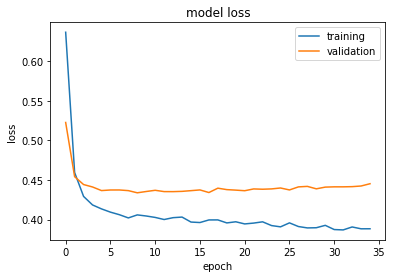

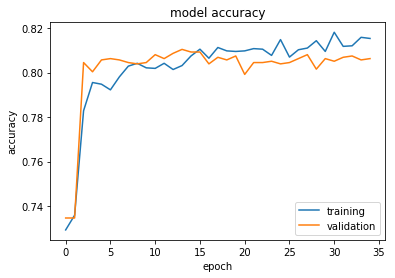

In [34]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'])
plt.show()
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'])
plt.show()



**Making Predictions**

We’ve got a good model based on the validation accuracy. Now let’s make some predictions from our keras model on the test data set, which was unseen during modeling (we use this for the true performance assessment). We have two functions to generate predictions:

predict_classes(): Generates class values as a matrix of ones and zeros. Since we are dealing with binary classification, we’ll convert the output to a vector.

predict_proba(): Generates the class probabilities as a numeric matrix indicating the probability of being a class. Again, we convert to a numeric vector because there is only one column output.


In [35]:
# Generate class predictions for the input samples batch by batch.
# Predicted Class
keras_class_vec = model.predict_classes(np.array(x_test_tbl.values))
# keep the predictions for class 1 only

# Generates class probability predictions for the input samples batch by batch.
# Predicted Class Probability
keras_prob_vec = model.predict_proba(np.array(x_test_tbl.values))

### Inspect Performance

In [36]:
#good
truth = y_test_vec.astype(object)
estimate = keras_class_vec.astype(object)
class_prob = keras_prob_vec

In [37]:
def estimates_keras_tbl(truth, estimate, class_prob):
    print('%-10s %-15s %s' %('truth', 'estimate', 'class_prob'))
    for i, (truth, estimate, class_prob) in enumerate(zip(truth[0:25].tolist(), estimate[0:25].tolist(), class_prob.tolist())):
        print(('%-3s %-11s %-8s %.012s' %('', truth, estimate, class_prob)))
estimates_keras_tbl(truth, estimate, class_prob)

truth      estimate        class_prob
    1           [0]      [0.203351557
    0           [0]      [0.137137055
    1           [1]      [0.569357514
    0           [0]      [0.154345765
    1           [0]      [0.286412447
    0           [0]      [0.053786076
    1           [1]      [0.672843217
    0           [0]      [0.006392090
    0           [0]      [0.012360554
    1           [1]      [0.596973061
    1           [1]      [0.669666945
    0           [0]      [0.031194588
    1           [0]      [0.145800232
    0           [0]      [0.354184389
    0           [0]      [0.351980149
    0           [0]      [0.022097697
    0           [0]      [0.041187949
    1           [0]      [0.423010051
    0           [0]      [0.487699687
    1           [1]      [0.628908514
    0           [0]      [0.056432455
    0           [0]      [0.001960021
    0           [0]      [0.425483226
    0           [1]      [0.788870036
    0           [1]      [0.775875329


**Confusion table**

We can use the confusion_matrix() function to get the confusion table. We see that the model was by no means perfect, but it did a decent job of identifying customers likely to churn.

In [38]:
from sklearn.metrics import confusion_matrix
confusion_matrix(truth.tolist(), estimate.tolist())

array([[931,  95],
       [184, 197]])

**Accuracy**

We can use the metrics() function to get an accuracy measurement from the test set. We are getting roughly 80% accuracy.

In [39]:
from sklearn.metrics import accuracy_score
accuracy_score(truth.tolist(), estimate.tolist())

0.8017057569296375

**AUC**

We can also get the ROC Area Under the Curve (AUC) measurement. AUC is often a good metric used to compare different classifiers and to compare to randomly guessing (AUC_random = 0.50). Our model has AUC = 0.71, which is much better than randomly guessing. Tuning and testing different classification algorithms may yield even better results.

In [40]:
from sklearn.metrics import roc_auc_score
roc_auc_score(truth.tolist(), estimate.tolist())

0.7122338874307379

**Precision and recall**

Precision is when the model predicts “yes”, how often is it actually “yes”. Recall (also true positive rate or specificity) is when the actual value is “yes” how often is the model correct.

In [41]:
# STUDY what is the diference between:  average='weighted', average='micro', average='macro' !!!!!

from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score

precision = average_precision_score(truth.tolist(), estimate.tolist())
print('Average precision score: ', precision)

recall = recall_score(truth.tolist(), estimate.tolist()) 
print('Average recall score: ', recall)

Average precision score:  0.4796133705020669
Average recall score:  0.5170603674540682


**F1 Score**

We can also get the F1-score, which is a weighted average between the precision and recall. Machine learning classifier thresholds are often adjusted to maximize the F1-score. However, this is often not the optimal solution to the business problem.

In [42]:
# STUDDY what is the diference between:  average='weighted', average='micro', average='macro' !!!!!
# f1_score(y_true, y_pred, average='macro') 

from sklearn.metrics import f1_score

f1_score = f1_score(truth.tolist(), estimate.tolist())
print('F1 Statistic: ', f1_score)

F1 Statistic:  0.5854383358098069


### Explain The Model

LIME stands for Local Interpretable Model-agnostic Explanations, and is a method for explaining black-box machine learning model classifiers. For those new to LIME, this YouTube video does a really nice job explaining how LIME helps to identify feature importance with black box machine learning models (e.g. deep learning, stacked ensembles, random forest).

__Feature Importance Visualization__

The payoff for the work we put in using LIME is this feature importance plot. This allows us to visualize each of the first ten cases (observations) from the test data. The top four features for each case are shown. Note that they are not the same for each case. The green bars mean that the feature supports the model conclusion, and the red bars contradict. A few important features based on frequency in first ten cases:

### Check Explanations With Correlation Analysis

We can perform a correlation analysis on the training set as well to help glean what features correlate globally to “Churn”. We can get the correlations as follows.

In [43]:
# Feature correlations to Churn
x_train_tbl["Churn"] = y_train_vec
x_train_tbl[x_train_tbl.columns[:]].corr()["Churn"][:]

SeniorCitizen                            0.148002
MonthlyCharges                           0.188645
TotalCharges                            -0.239521
gender_Male                             -0.012693
Partner_Yes                             -0.151554
Dependents_Yes                          -0.163059
tenure_bin1                              0.292358
tenure_bin2                              0.103361
tenure_bin3                              0.004767
tenure_bin4                             -0.065942
tenure_bin5                             -0.138090
tenure_bin6                             -0.204378
PhoneService_Yes                         0.007371
MultipleLines_No phone service          -0.007371
MultipleLines_Yes                        0.033836
InternetService_Fiber optic              0.306237
InternetService_No                      -0.227412
OnlineBackup_No internet service        -0.227412
OnlineBackup_Yes                        -0.085164
OnlineSecurity_No internet service      -0.227412


In [44]:
# BIG CORRELATION MATRIX
# x_train_tbl["Churn"] = y_train_vec
# x_train_tbl[x_train_tbl[:].columns[:]].corr()[:]
x_train_tbl.pop('Churn')
x_train_tbl.to_csv("aa.csv")
x_train_tbl.head()

,SeniorCitizen,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,tenure_bin1,tenure_bin2,tenure_bin3,tenure_bin4,...,PaymentMethod_Electronic check,PaymentMethod_Mailed check,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes
0,-0.440327,-1.161694,-2.281544,-1.009430,1.035617,-0.652305,2.175098,-0.438254,-0.453153,-0.446985,...,1.404764,-0.543604,-0.52513,-0.723918,-0.52513,-0.639260,-0.52513,-0.790186,-0.52513,-0.796849
1,-0.440327,-0.260878,0.389297,0.990658,-0.965608,-0.652305,-0.459749,-0.438254,-0.453153,2.237213,...,-0.711863,1.839576,-0.52513,1.381372,-0.52513,-0.639260,-0.52513,-0.790186,-0.52513,-0.796849
2,-0.440327,-0.363923,-1.452624,0.990658,-0.965608,-0.652305,2.175098,-0.438254,-0.453153,-0.446985,...,-0.711863,1.839576,-0.52513,-0.723918,-0.52513,-0.639260,-0.52513,-0.790186,-0.52513,-0.796849
3,-0.440327,-0.747850,0.372466,0.990658,-0.965608,-0.652305,-0.459749,-0.438254,-0.453153,2.237213,...,-0.711863,-0.543604,-0.52513,1.381372,-0.52513,1.564308,-0.52513,-0.790186,-0.52513,-0.796849
4,-0.440327,0.196178,-1.234948,-1.009430,-0.965608,-0.652305,2.175098,-0.438254,-0.453153,-0.446985,...,1.404764,-0.543604,-0.52513,-0.723918,-0.52513,-0.639260,-0.52513,-0.790186,-0.52513,-0.796849


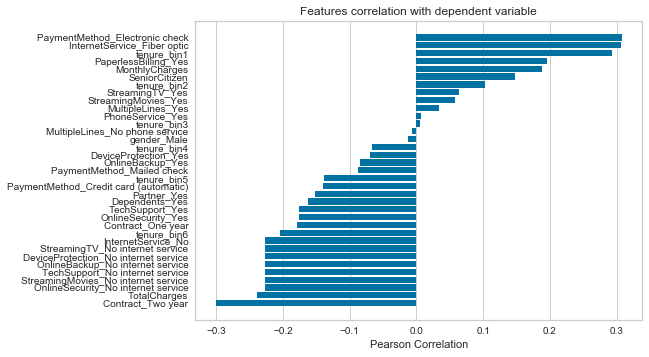

In [45]:
# The correlation visualization helps in distinguishing which features are relavant to Churn.
# Correlation visualization
from sklearn import datasets
from yellowbrick.target import FeatureCorrelation

feature_names = np.array(x_train_tbl.columns)

visualizer = FeatureCorrelation(labels=feature_names, sort = True)
visualizer.fit(x_train_tbl, y_train_vec)
visualizer.poof()

_Positive correlations contribute to churn and negative correlations prevent churn_

The correlation analysis helps us quickly disseminate which features that the LIME analysis may be excluding. We can see that the following features are highly correlated (magnitude > TODO):

Increases Likelihood of Churn: 
- Tenure = Bin 1 (<12 Months) 
- Internet Service = “Fiber Optic” 
- Payment Method = “Electronic Check”

Decreases Likelihood of Churn: 
- Contract = “Two Year” 
- Total Charges (Note that this may be a biproduct of additional services such as Online Security)

### Feature Investigation

We can investigate features that are most frequent in the feature importance visualization along with those that the correlation analysis shows an above normal magnitude. We’ll investigate:

- Tenure (Highly Correlated)
- Contract (Highly Correlated)
- Internet Service (Highly Correlated)
- Payment Method (Highly Correlated)
- Senior Citizen 
- Online Security 

__Tenure (highly correlated)__

LIME cases indicate that the ANN model is using this feature frequently and high correlation agrees that this is important. Investigating the feature distribution, it appears that:

> customers with lower tenure (bin 1) are more likely to leave. 
__Opportunity: Target customers with less than 12 month tenure.__


Text(0.5, 0, 'Churn')

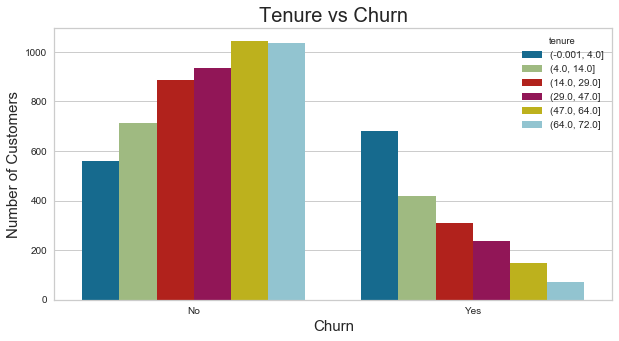

In [46]:
import seaborn as sns
plot_data = pd.read_csv("Telco_Customer_Churn.csv")
plot_data['tenure'] = pd.qcut(plot_data["tenure"], 6)
plt.figure(figsize=(10,5))
ax = sns.countplot(x="Churn", hue='tenure', data = plot_data);
ax.set_title('Tenure vs Churn', fontsize=20)
ax.set_ylabel('Number of Customers', fontsize = 15)
ax.set_xlabel('Churn', fontsize = 15)

__Contract (highly correlated)__

While LIME did not indicate this as a primary feature in the first 10 cases, the feature is clearly correlated with those electing to stay. 

> Customers with one and two year contracts are much less likely to churn. 
__Opportunity: Offer promotion to switch to long term contracts.__


Text(0.5, 0, 'Churn')

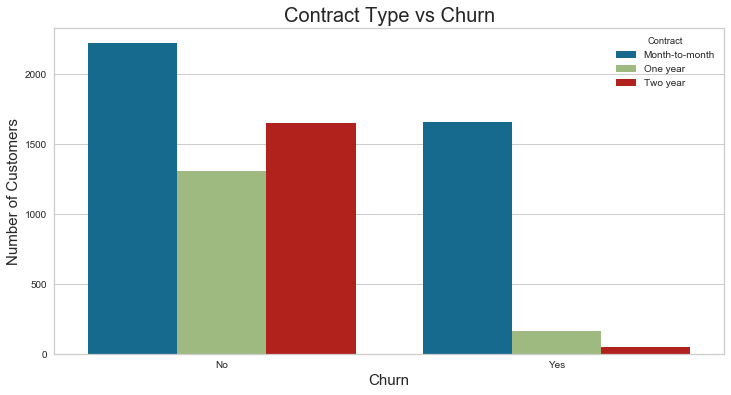

In [47]:
plot_data = pd.read_csv("Telco_Customer_Churn.csv")
 
plt.figure(figsize=(12,6))
ax = sns.countplot(x="Churn", hue="Contract", data = plot_data);
ax.set_title('Contract Type vs Churn', fontsize=20)
ax.set_ylabel('Number of Customers', fontsize = 15)
ax.set_xlabel('Churn', fontsize = 15)

__Internet Service (highly correlated)__

While LIME did not indicate this as a primary feature in the first 10 cases, the feature is clearly correlated with those electing to stay. Customers with fiber optic service are more likely to churn while those with no internet service are less likely to churn. Improvement Area: Customers may be dissatisfied with fiber optic service.

Text(0.5, 0, 'Churn')

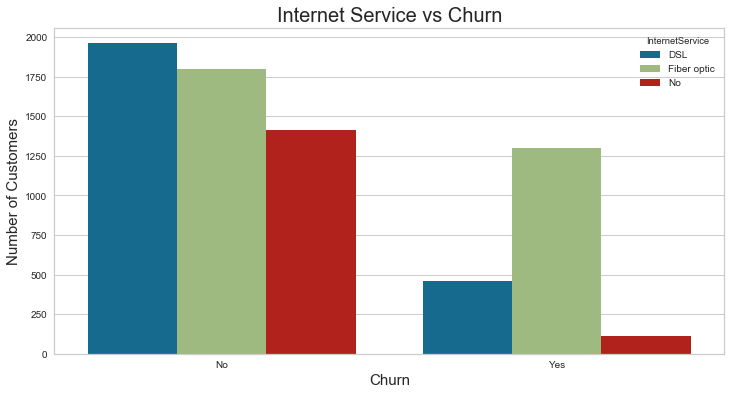

In [48]:
plot_data = pd.read_csv("Telco_Customer_Churn.csv")
 
plt.figure(figsize=(12,6))
ax = sns.countplot(x="Churn", hue="InternetService", data = plot_data);
ax.set_title('Internet Service vs Churn', fontsize=20)
ax.set_ylabel('Number of Customers', fontsize = 15)
ax.set_xlabel('Churn', fontsize = 15)

__Payment Method (highly correlated)__

While LIME did not indicate this as a primary feature in the first 10 cases, the feature is clearly correlated with those electing to stay. 

>Customers with electronic check are more likely to leave. __Opportunity: Offer customers a promotion to switch to automatic payments.__

Text(0.5, 0, 'Churn')

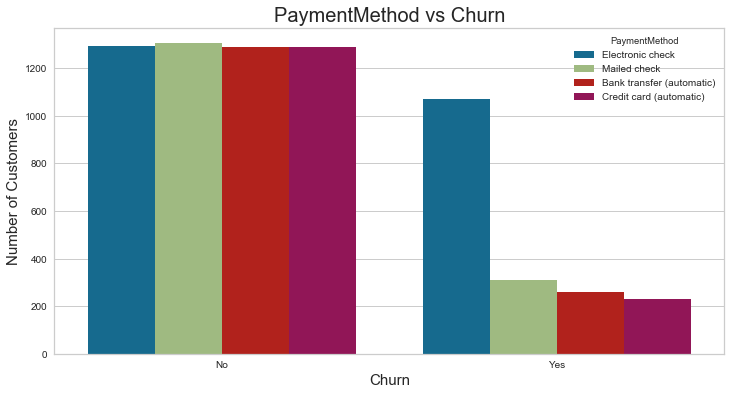

In [49]:
plot_data = pd.read_csv("Telco_Customer_Churn.csv")
 
plt.figure(figsize=(12,6))
ax = sns.countplot(x="Churn", hue="PaymentMethod", data = plot_data);
ax.set_title('PaymentMethod vs Churn', fontsize=20)
ax.set_ylabel('Number of Customers', fontsize = 15)
ax.set_xlabel('Churn', fontsize = 15)

__Senior Citizen (5/10 LIME CASES)__

Senior citizen appeared in several of the LIME cases indicating it was important to the ANN for the 10 samples. However, it was not highly correlated to Churn, which may indicate that the ANN is using in an more sophisticated manner (e.g. as an interaction). 

>It’s difficult to say that senior citizens are more likely to leave, but non-senior citizens appear less at risk of churning. __Opportunity: Target users in the lower age demographic.__


Text(0.5, 0, 'Churn')

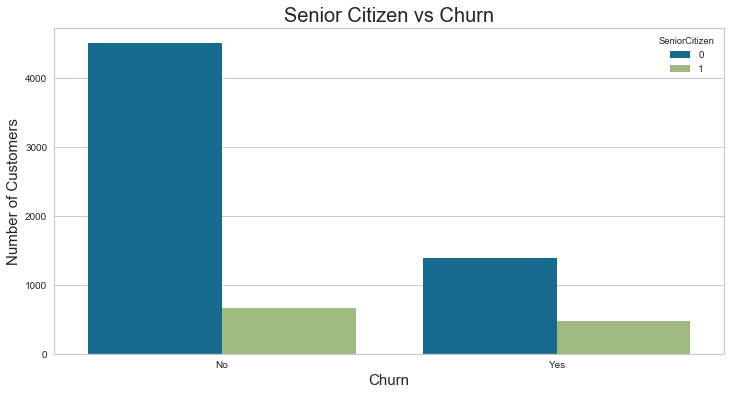

In [50]:
plot_data = pd.read_csv("Telco_Customer_Churn.csv")
 
plt.figure(figsize=(12,6))
ax = sns.countplot(x="Churn", hue="SeniorCitizen", data = plot_data);
ax.set_title('Senior Citizen vs Churn', fontsize=20)
ax.set_ylabel('Number of Customers', fontsize = 15)
ax.set_xlabel('Churn', fontsize = 15)

__Online Security (4/10 LIME CASES)__

Customers that did not sign up for online security were more likely to leave while customers with no internet service or online security were less likely to leave. __Opportunity: Promote online security and other packages that increase retention rates.__

Text(0.5, 0, 'Churn')

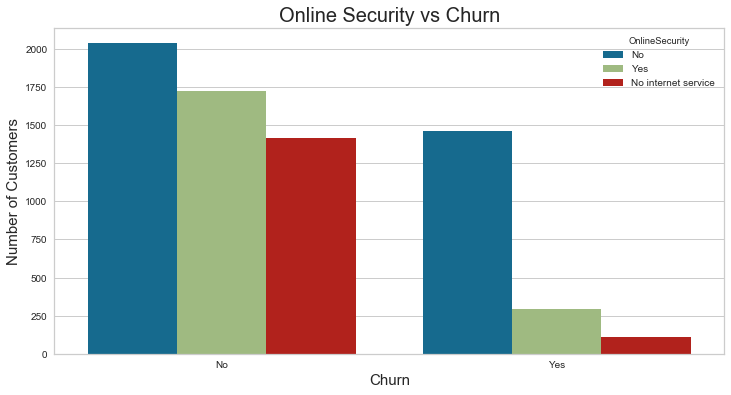

In [51]:
plot_data = pd.read_csv("Telco_Customer_Churn.csv")
 
plt.figure(figsize=(12,6))
ax = sns.countplot(x="Churn", hue="OnlineSecurity", data = plot_data);
ax.set_title('Online Security vs Churn', fontsize=20)
ax.set_ylabel('Number of Customers', fontsize = 15)
ax.set_xlabel('Churn', fontsize = 15)

### Conclusions

Customer churn is a costly problem. The good news is that machine learning can solve churn problems, making the organization more profitable in the process. In this article, we saw how Deep Learning can be used to predict customer churn. We built an ANN model using the new keras package that achieved 73% predictive accuracy! We checked our results with a Correlation Analysis, which brought to light other features to investigate. For the IBM Telco dataset, tenure, contract type, internet service type, payment menthod, senior citizen status, and online security status were useful in diagnosing customer churn.